In [1]:
from src import functions as fncs
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.patches as patches
from matplotlib import pyplot as plt

<h3>Area Skotniki</h3>

In [2]:
# pickup points Skotniki
p_points = gpd.read_file('data/area_skotniki/Lajkobus_miejsca_odbioru.shp')

In [3]:
p_points

,typ_miejsc,nazwa_miej,uwagi,geometry
0,miejsce_odbioru,Frassati-Gawrońskiej 1,None,POINT (2214561.954 6450163.584)
1,miejsce_odbioru,Podole 1,None,POINT (2214247.786 6450078.293)
2,miejsce_odbioru,Podole 2,None,POINT (2213852.794 6450057.265)
3,miejsce_odbioru,KMK Czerwone Maki P+R 06,None,POINT (2213994.093 6449429.066)
4,miejsce_odbioru,Sternbacha 1,None,POINT (2213968.334 6449561.807)
...,...,...,...,...
78,miejsce_odbioru,KMK Mochnaniec 02,None,POINT (2213161.639 6449154.065)
79,miejsce_odbioru,KMK Mochnaniec 01,None,POINT (2213270.754 6449167.928)
80,miejsce_odbioru,Obrońców Helu 8,None,POINT (2213737.048 6449376.223)
81,miejsce_oczekiwania,KMK Czerwone Maki P+R 04,None,POINT (2214023.433 6449429.191)


In [4]:
# pickup point type
p_points['typ_miejsc'].value_counts()

typ_miejsc
miejsce_odbioru                78
miejsce_oczekiwania_odbioru     3
miejsce_oczekiwania             2
Name: count, dtype: int64

In [5]:
# change coordinate reference system (CRS) to EPSG:4326
p_points = p_points.to_crs(4326)

In [6]:
# form tuples with pickup point coordinates to calculate shortest distances
pickups = [(p[1]['x'], p[1]['y'], p[0]) for p in p_points['geometry'].get_coordinates().iterrows()]
# pickups[:5]

In [7]:
# read data for area Skotniki
area = gpd.read_file('data/area_skotniki/obszary_usługi.shp')
area

,nazwa,geometry
0,Skotniki,"POLYGON ((2213969.093 6449259.687, 2214126.555..."


In [8]:
# change coordinate reference system (CRS) to EPSG:4326
area = area.to_crs(4326)
area

,nazwa,geometry
0,Skotniki,"POLYGON ((19.88842 50.01723, 19.88984 50.01762..."


In [9]:
# read demographic of the city
addr_points = pd.read_csv('data/krk_demographic.csv', index_col=0)
addr_points = addr_points.rename(columns={"adr_pelny": "address", "ogolem": "total" })
addr_points

,x,y,address,total
FID,,,,
0,19.996604,50.086510,STANISŁAWA SKARŻYŃSKIEGO 9,975
1,20.014369,50.083876,OSIEDLE KOŚCIUSZKOWSKIE 6,955
2,19.997005,50.085446,STANISŁAWA SKARŻYŃSKIEGO 5,832
3,20.021469,50.086969,OSIEDLE KAZIMIERZOWSKIE 29,785
4,19.996731,50.084792,STANISŁAWA SKARŻYŃSKIEGO 3,775
...,...,...,...,...
47705,19.978465,50.072244,OSTATNIA 27,1
47706,19.954666,50.057313,KAROLA CHODKIEWICZA 10C,1
47707,19.879556,50.085813,WŁODZIMIERZA TETMAJERA 17A,1


In [10]:
# filter address points locating inside the Skotniki area
addr_points = addr_points.copy()
addr_points['inside_area'] = addr_points.apply(lambda row: 
                            area.geometry[0].contains(Point(row['x'], row['y'])), axis=1)
addr_points = addr_points[addr_points['inside_area'] == True].reset_index(drop=True)
addr_points

,x,y,address,total,inside_area
0,19.881557,50.012738,JANA KANTEGO FEDEROWICZA 5,156,True
1,19.883339,50.012922,JANA KANTEGO FEDEROWICZA 1,100,True
2,19.882427,50.013276,JANA KANTEGO FEDEROWICZA 7,99,True
3,19.884263,50.014585,KAROLA BUNSCHA 20,96,True
4,19.883469,50.013328,JANA KANTEGO FEDEROWICZA 9,78,True
...,...,...,...,...,...
1224,19.875240,50.009562,SKOTNICKA 135,1,True
1225,19.879973,50.015135,SZYMONA SZYMONOWICA 9I<,1,True
1226,19.867944,50.006777,KOZIENICKA 22,1,True
1227,19.886584,50.018872,OBROŃCÓW HELU 8,1,True


In [11]:
sum(addr_points.total)

6070

In [12]:
# calculate closest distance between the address point and the pickup point
closest_distance = lambda point: min([fncs.haversine(point, pickup)
                                        for pickup in pickups])
# find the closest pickup point
closest = lambda point: p_points.iloc[min([(fncs.haversine(point, pickup), pickup)
                                        for pickup in pickups])[1][2], :]

In [13]:
# test
closest((addr_points.loc[0, :].x, addr_points.loc[0, :].y)),\
      closest_distance((addr_points.loc[0, :].x, addr_points.loc[0, :].y))

(typ_miejsc                                 miejsce_odbioru
 nazwa_miej                                  KMK Bunscha 02
 uwagi                                                 None
 geometry      POINT (19.883213197741057 50.01216565646026)
 Name: 6, dtype: object,
 0.19367141827901604)

In [14]:
closest_pickups = addr_points.apply(lambda row: closest((row.x, row.y)), axis=1)
closest_pickups

,typ_miejsc,nazwa_miej,uwagi,geometry
0,miejsce_odbioru,KMK Bunscha 02,None,POINT (19.883213197741057 50.01216565646026)
1,miejsce_odbioru,KMK Bunscha 01,None,POINT (19.883880883282227 50.01264981834883)
2,miejsce_odbioru,KMK Bunscha 02,None,POINT (19.883213197741057 50.01216565646026)
3,miejsce_odbioru,Bunscha 5,None,POINT (19.885583163461877 50.01557628517615)
4,miejsce_odbioru,KMK Bunscha 01,None,POINT (19.883880883282227 50.01264981834883)
...,...,...,...,...
1224,miejsce_odbioru,KMK Skotniki Kościół 01,None,POINT (19.874701214646798 50.00900804468515)
1225,miejsce_odbioru,Federowicza 1,None,POINT (19.879771400749778 50.01591492564253)
1226,miejsce_odbioru,KMK Fort Skotniki 02,None,POINT (19.869367360448496 50.00667371844385)
1227,miejsce_odbioru,Obrońców Helu 8,None,POINT (19.88633824811294 50.01789907469161)


In [15]:
addr_points['pickup_name'], addr_points['geometry'] = closest_pickups['nazwa_miej'], closest_pickups['geometry']
addr_points.drop('inside_area', axis=1, inplace=True)

In [16]:
addr_points['distance'] = addr_points.apply(lambda row: closest_distance((row.x, row.y)), axis=1)
addr_points.head(3)

,x,y,address,total,pickup_name,geometry,distance
0,19.881557,50.012738,JANA KANTEGO FEDEROWICZA 5,156,KMK Bunscha 02,POINT (19.883213197741057 50.01216565646026),0.193671
1,19.883339,50.012922,JANA KANTEGO FEDEROWICZA 1,100,KMK Bunscha 01,POINT (19.883880883282227 50.01264981834883),0.066631
2,19.882427,50.013276,JANA KANTEGO FEDEROWICZA 7,99,KMK Bunscha 02,POINT (19.883213197741057 50.01216565646026),0.145338


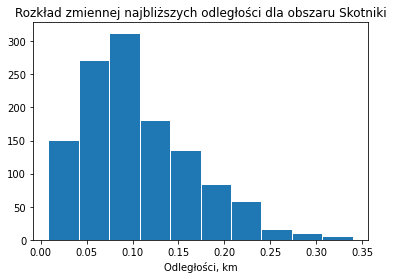

In [17]:
dists = addr_points['distance']
plt.hist(dists, edgecolor='white')
# plt.title('Closest distances distribution')
plt.title('Rozkład zmiennej najbliższych odległości dla obszaru Skotniki')
plt.xlabel('Odległości, km')
# plt.savefig('results/images/skotniki_dist_distrib_pl.png', dpi=100)
plt.show()

In [18]:
dists = np.array(dists)
print('statystyki obszaru Skotniki:', '\nmean:', round(dists.mean(), 3), '\nstandard deviation:', round(dists.std(), 3),\
      '\nmin:', round(dists.min(), 3), 'max:', round(dists.max(), 3))

statystyki obszaru Skotniki: 
mean: 0.106 
standard deviation: 0.06 
min: 0.008 max: 0.34


In [20]:
pSUM = pd.read_csv('input/demand_SUM(S).csv', index_col=0)
pSUM.head(3)

,origin_x,origin_y,destination_x,destination_y,treq,index,hub,ttrav,tarr,u,ttrav_sh,tarr_sh,u_sh,u_PT_OD,u_PT_HD_ASC,u_SUM_OD,p_SUM,r
2,19.886108,50.018298,19.982455,50.018291,2024-03-28 08:09:08,2,1989392511,356,2024-03-28 08:15:04,4.4515,384.0,2024-03-28 08:15:32,4.377575,13.793519,12.272955,17.875284,0.016598,1
8,19.865694,50.015256,19.941533,50.041045,2024-03-28 07:56:47,8,1989392511,284,2024-03-28 08:01:31,3.5515,284.0,2024-03-28 08:01:31,3.342750,15.673457,7.019790,12.943317,0.938782,1
9,19.870060,50.018005,19.929164,50.042483,2024-03-28 07:50:09,9,1989392511,159,2024-03-28 07:52:48,1.9950,159.0,2024-03-28 07:52:48,1.995000,14.302728,6.749778,11.325555,0.951532,1


In [21]:
exmas_addr = addr_points.iloc[addr_points.index.isin(pSUM['index'])]
exmas_addr.head()

,x,y,address,total,pickup_name,geometry,distance
2,19.882427,50.013276,JANA KANTEGO FEDEROWICZA 7,99,KMK Bunscha 02,POINT (19.883213197741057 50.01216565646026),0.145338
8,19.882381,50.012842,JANA KANTEGO FEDEROWICZA 3,38,KMK Bunscha 02,POINT (19.883213197741057 50.01216565646026),0.116539
9,19.882194,50.014271,JANA KANTEGO FEDEROWICZA 29,34,KMK Bunscha 02,POINT (19.883213197741057 50.01216565646026),0.247575
12,19.880490,50.014193,JANA KANTEGO FEDEROWICZA 35,25,Federowicza 1,POINT (19.879771400749778 50.01591492564253),0.196946
17,19.881605,50.014216,JANA KANTEGO FEDEROWICZA 31,19,KMK Mochnaniec 02,POINT (19.881169268503257 50.016616737726274),0.255718


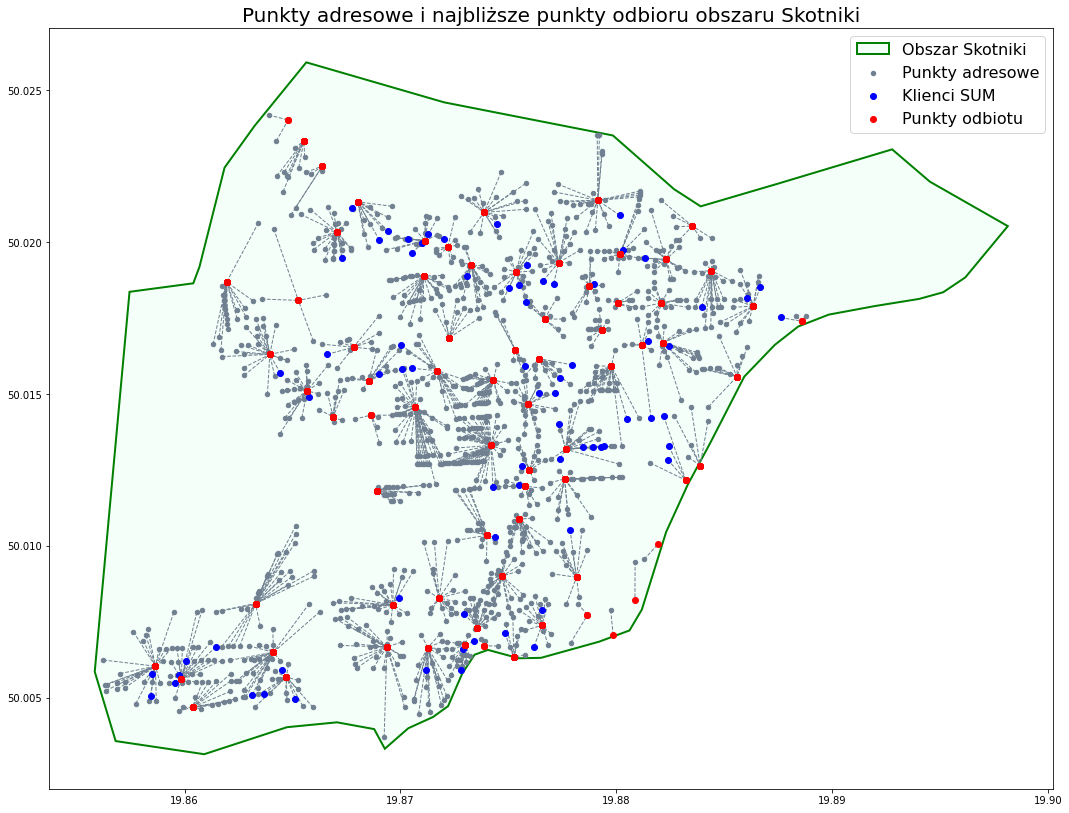

In [22]:
p_xs = [addr_points['geometry'][i].x for i in range(len(addr_points))]
p_ys = [addr_points['geometry'][i].y for i in range(len(addr_points))]

fig, ax = plt.subplots(figsize=(18, 14))
# polygon_patch = patches.Polygon(area.geometry[0].exterior.coords, closed=True, \
#                                 fill=False, edgecolor='green', linewidth=2, label='Skotniki Area')
polygon_patch = patches.Polygon(area.geometry[0].exterior.coords, closed=True, \
                                facecolor='mintcream', fill=True, edgecolor='green', linewidth=2, label='Obszar Skotniki')
ax.add_patch(polygon_patch)
# connections
for i in range(len(addr_points)):
    ax.plot([addr_points.loc[i, 'x'], addr_points['geometry'][i].x],
            [addr_points.loc[i, 'y'], addr_points['geometry'][i].y], 'k--', color='slategray', zorder=1, linewidth=1)

# address points
# ax.scatter(addr_points['x'], addr_points['y'], color='blue', label='Address Points')
ax.scatter(addr_points['x'], addr_points['y'], color='slategray', zorder=2, label='Punkty adresowe', s=20)
# address points that use ExMAS
ax.scatter(exmas_addr['x'], exmas_addr['y'], color='blue', zorder=3, label='Klienci SUM')
# pickup points
# ax.scatter(p_xs, p_ys, color='red', label='Pickup Points')
ax.scatter(p_xs, p_ys, color='red', zorder=4, label='Punkty odbiotu')

ax.legend(fontsize=16)
# ax.set_xlabel('X Coordinate', fontsize=16)
# ax.set_ylabel('Y Coordinate', fontsize=16)
# ax.set_title('Address Points and Closest Pickup Points', fontsize=20)

ax.set_title('Punkty adresowe i najbliższe punkty odbioru obszaru Skotniki', fontsize=20)
# plt.savefig('results/images/skotniki_shortest_dist_pl.png', dpi=100)

plt.show()